In [12]:
%%writefile util.py
import re
import json
import numpy as np
import pandas as pd

from tqdm import tnrange
import matplotlib.pyplot as plt
from math import ceil,floor,log
from os import listdir,remove
from os.path import join,exists
from scipy.sparse import csr_matrix
from sklearn.preprocessing import LabelEncoder


def r_prec(y_true,y_pred):
    keys=y_true.keys()&y_pred.keys()
    n=len(keys)
    s=0
    for i in keys:
        s += len(set(y_true[i])&set(y_pred[i]))/len(y_true[i])
    return s/n

assert r_prec({1:[1,2,3,4]},{1:[2,3,4,5]}) == 0.75

def clicks(y_true,y_pred):
    keys=y_true.keys()&y_pred.keys()
    n=len(keys)
    s=0
    for i in keys:
        c=51
        y_set=set(y_true[i])
        for j,y in enumerate(y_pred[i]):
            if y in y_set:
                c=j//10+1
                break
        s += c
    return s/n

assert clicks({1:[1,2,3,4]},{1:[0,0,0,0,0,0,0,0,0,0,0,1,0,2]}) == 2

def ndcg(y_true,y_pred):
    keys=y_true.keys()&y_pred.keys()
    n=len(keys)
    s=0
    for j in keys:
        dcg = 0
        y_set=set(y_true[j])
        for i,y in enumerate(y_pred[j]):
            if i == 0:
                i = 1
            if y in y_set:
                dcg += 1/log(i+1,2) 
        idcg=1
        y_set=set(y_pred[j])
        for i,y in enumerate(y_true[j]):
            if i > 0 and y in y_set:
                idcg += 1/log(i+1,2)
        s += dcg/idcg 
    return s/n

assert ndcg({1:[1,2,3,4]},{1:[2,1,0,4,3]})==(1+1/log(2,2)+1/log(4,2)+1/log(5,2))/(1+1/log(2,2)+1/log(3,2)+1/log(4,2))

def load_train_data(size_flag):
#     tracks.to_csv('raw/%s/tracks.csv'%size_flag,index=False)
#     albums.to_csv('raw/%s/albums.csv'%size_flag,index=False)
#     artists.to_csv('raw/%s/artists.csv'%size_flag,index=False)

    playlists=pd.read_csv('raw/%s/playlists.csv'%size_flag)
    playlist_tracks=pd.read_csv('raw/%s/playlist_tracks.csv'%size_flag)
    tracks=pd.read_csv('raw/%s/tracks.csv'%size_flag)
#     album_track.to_csv('raw/%s/album_tracks.csv'%size_flag,index=False)
#     artist_track.to_csv('raw/%s/artist_tracks.csv'%size_flag,index=False)
#     playlist_track.to_csv('raw/%s/playlist_tracks.csv'%size_flag,index=False)
    return playlists,playlist_tracks,tracks

def load_test_data():
    playlists=pd.read_csv('raw/test/playlists.csv')
    playlist_tracks=pd.read_csv('raw/test/playlist_tracks.csv')
    return playlists,playlist_tracks

def split_data(playlists,playlist_tracks,test_size=0.1,seed=42):
    playlists.index=playlists.pid
    
    np.random.seed=seed
    slice_track_nums=[0,1,5,5,10,10,25,25,100,100]
    keep_types=[0,0,0,0,0,0,0,1,0,1] # 1 means random select tracks
    no_name_splits=[3,5]
    slice_pl_n=int(playlists.shape[0]*test_size)//len(slice_track_nums)
    test_ptracks=[]
    true_ptracks=[]
    ptrack_cnts=playlist_tracks.groupby('pid')[['track_id']].count()
    tst_pids=set([-1])
    for i in tnrange(len(slice_track_nums)-1,-1,-1):
        track_n=slice_track_nums[i]
        pids=set(ptrack_cnts[ptrack_cnts.track_id>track_n].index)
        slice_pids=set([-1])
        k = 0
        for pid in pids:
            if pid not in tst_pids:
                tst_pids.add(pid)
                slice_pids.add(pid)
                k+=1
                if k==slice_pl_n:
                    break
        assert k == slice_pl_n
        slice_pids.remove(-1)
        if keep_types[i] == 0:
            for pid in slice_pids:
                ptracks=playlist_tracks[playlist_tracks.pid == pid]
                test_ptracks.append(ptracks[ptracks.pos<track_n])
                true_ptracks.append(ptracks[ptracks.pos>=track_n])
        else:
            for pid in slice_pids:
                ptracks=playlist_tracks[playlist_tracks.pid == pid]
                rnd_idx=np.random.permutation(ptracks.shape[0])
                test_idx = rnd_idx[:track_n]
                true_idx = rnd_idx[track_n:]
                test_ptracks.append(ptracks.iloc[test_idx])
                true_ptracks.append(ptracks.iloc[true_idx])
        if i in no_name_splits:
            playlists.loc[slice_pids,'name']=np.nan
                    
    tst_pids.remove(-1)
    
    playlists_tst=playlists.loc[tst_pids]
    tra_pids = set(playlists.index.difference(tst_pids))
    playlists_tra=playlists.loc[tra_pids]
    
    playlist_tracks_tra=playlist_tracks[playlist_tracks.pid.apply(lambda p:p in tra_pids)]
    
    playlist_tracks_tst=pd.concat(test_ptracks)
    playlist_tracks_tru=pd.concat(true_ptracks)
    
    assert playlists_tst.shape[0] == playlist_tracks_tru.pid.nunique()
    
    return playlists_tra,playlists_tst,playlist_tracks_tra,playlist_tracks_tst,playlist_tracks_tru

def load_small_data():
    playlists,playlist_tracks,tracks=load_train_data('small')
    playlists_tra,playlists_tst,playlist_tracks_tra,playlist_tracks_tst,playlist_tracks_tru=split_data(playlists,playlist_tracks,test_size=0.01)
    return playlists_tra,playlists_tst,playlist_tracks_tra,playlist_tracks_tst,playlist_tracks_tru,tracks,playlists,playlist_tracks

def load_large_data():
    return pd.read_csv('raw/large/playlists_tra.csv'),\
pd.read_csv('raw/large/playlists_tst.csv'),\
pd.read_csv('raw/large/playlist_tracks_tra.csv'),\
pd.read_csv('raw/large/playlist_tracks_tst.csv'),\
pd.read_csv('raw/large/playlist_tracks_tru.csv'),\
pd.read_csv('raw/large/tracks.csv')

def load_data():
    return pd.read_csv('raw/large/playlists.csv'),\
pd.read_csv('raw/test/playlists.csv'),\
pd.read_csv('raw/large/playlist_tracks.csv'),\
pd.read_csv('raw/test/playlist_tracks.csv'),\
pd.read_csv('raw/large/tracks.csv')

def ytrue(playlists_tst,playlist_tracks_tru):
    y_true={}
    pids=sorted(playlists_tst.pid)
    for pid in pids:
        y_true[pid]=playlist_tracks_tru[playlist_tracks_tru.pid == pid].track_id
    return y_true

def cos_sim(a,b):
    return np.dot(a,b.T)/((np.sum(a**2)**0.5)*(np.sum(b**2)**0.5))

pattern = re.compile('[\W_]+')
def build_title(name):
    n=str(name).lower()
    words=n.split()
    for i,w in enumerate(words):
        words[i]=pattern.sub('', w)
    w=' '.join(words)
    if len(w)==0:
        w = 'unknown'
    return w

def df_to_ffm(file,x,y,cat_cols):
    x.index=np.arange(x.shape[0])
    y.index=np.arange(x.shape[0])
    cat_idx=set([-1])
    for i in range(x.shape[1]):
        if x.columns[i] in cat_cols:
            cat_idx.add(i)
            
    with open(file,'w') as f:
        for i in range(x.shape[0]):
            s=str(y[i])
            
            for j in range(x.shape[1]):
                if j in cat_idx:
                    s += ' %d:%d:1' % (j,x.iat[i,j])
                else:
                    s += ' %d:%d:1' % (j,x.iat[i,j])
                    
            f.write(s+'\n')
        
        
def ffm_encode(df):
    cat_cols = df.select_dtypes(include=['O']).columns
    for c in cat_cols:
        l=LabelEncoder()
        df[c]=l.fit_transform(df[c]).astype('int32')
    
    return cat_cols



Overwriting util.py


In [140]:
playlists,playlist_tracks,_=load_train_data('small')
playlists.index=playlists.pid
playlists_tra,playlists_tst,playlist_tracks_tra,playlist_tracks_tst,playlist_tracks_tru=split_data(playlists,playlist_tracks,test_size=0.01)
playlists_tst.info()
playlist_tracks_tst.groupby('pid')[['track_id']].count().track_id.value_counts()

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 90112 to 427007
Data columns (total 11 columns):
collaborative    100 non-null bool
description      2 non-null object
duration_ms      100 non-null int64
modified_at      100 non-null int64
name             80 non-null object
num_albums       100 non-null int64
num_artists      100 non-null int64
num_edits        100 non-null int64
num_followers    100 non-null int64
num_tracks       100 non-null int64
pid              100 non-null int64
dtypes: bool(1), int64(8), object(2)
memory usage: 8.7+ KB


100    20
25     20
10     20
5      20
1      10
Name: track_id, dtype: int64

/home/cq/anaconda3/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [129]:
help(np.random.permutation)

Help on built-in function permutation:

permutation(...) method of mtrand.RandomState instance
    permutation(x)
    
    Randomly permute a sequence, or return a permuted range.
    
    If `x` is a multi-dimensional array, it is only shuffled along its
    first index.
    
    Parameters
    ----------
    x : int or array_like
        If `x` is an integer, randomly permute ``np.arange(x)``.
        If `x` is an array, make a copy and shuffle the elements
        randomly.
    
    Returns
    -------
    out : ndarray
        Permuted sequence or array range.
    
    Examples
    --------
    >>> np.random.permutation(10)
    array([1, 7, 4, 3, 0, 9, 2, 5, 8, 6])
    
    >>> np.random.permutation([1, 4, 9, 12, 15])
    array([15,  1,  9,  4, 12])
    
    >>> arr = np.arange(9).reshape((3, 3))
    >>> np.random.permutation(arr)
    array([[6, 7, 8],
           [0, 1, 2],
           [3, 4, 5]])



/home/cq/anaconda3/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [ ]:
playlists_tra.to_csv('raw/large/playlists_tra.csv',index=False)
playlists_tst.to_csv('raw/large/playlists_tst.csv',index=False)
playlist_tracks_tra.to_csv('raw/large/playlist_tracks_tra.csv',index=False)
playlist_tracks_tst.to_csv('raw/large/playlist_tracks_tst.csv',index=False)
playlist_tracks_tru.to_csv('raw/large/playlist_tracks_tru.csv',index=False)

In [62]:
playlists,playlist_tracks,_=load_train_data('small')
p_t_cnts=playlist_tracks.groupby('pid')[['track_id']].count().values
np.sum(p_t_cnts>100)/p_t_cnts.shape[0]

0.2264

/home/cq/anaconda3/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


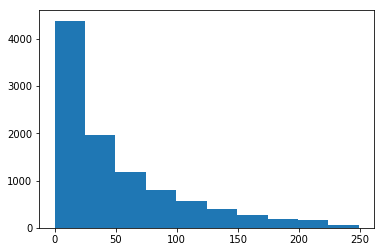

/home/cq/anaconda3/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [55]:
import matplotlib.pyplot as plt
%matplotlib inline
trk_cnts=[len(y) for y in y_true]
plt.hist(trk_cnts)
plt.show()

In [33]:
# assert len(playlist_tracks_tra.pid.unique())+len(playlist_tracks_tst.pid.unique()) == playlists.shape[0]
len(playlist_tracks_tra.pid.unique())+len(playlist_tracks_tst.pid.unique()), playlists.shape[0]
len(playlists_tra.pid.unique())+len(playlists_tst.pid.unique()), playlists.shape[0]

/home/cq/anaconda3/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


(1000000, 1000000)

In [27]:
# playlists,playlist_tracks,_=load_train_data('small')
# playlists.index=playlists.pid
# playlists_tra,playlists_tst,playlist_tracks_tra,playlist_tracks_tst=split_data(playlists,playlist_tracks)
# playlists_tst.info()

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 427000 to 427999
Data columns (total 11 columns):
collaborative    1000 non-null bool
description      27 non-null object
duration_ms      1000 non-null int64
modified_at      1000 non-null int64
name             800 non-null object
num_albums       1000 non-null int64
num_artists      1000 non-null int64
num_edits        1000 non-null int64
num_followers    1000 non-null int64
num_tracks       1000 non-null int64
pid              1000 non-null int64
dtypes: bool(1), int64(8), object(2)
memory usage: 86.9+ KB


/home/cq/anaconda3/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [ ]:
def loadGloveModel(gloveFile):
    print ("Loading Glove Model")
    f = open(gloveFile,'r')
    model = {}
    for line in f:
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    print ("Done.",len(model)," words loaded!")
    return model

# glove_model=loadGloveModel('raw/glove/glove.42B.300d.txt')